# Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
from tensorflow.keras.models import load_model


# Cloning and checking folders from github

In [ ]:
# GitHub repository URL
repo_url = "https://github.com/beingjumana/leukemia-cnn-model.git"

# Clone the repository if it doesn't already exist
if not os.path.exists("leukemia-cnn-model"):
    !git clone {repo_url}

# Change directory to the repository
%cd leukemia-cnn-model

# Define the image folders
dataset_folder = "data"
original_folder = os.path.join(dataset_folder, "Original")
segmented_folder = os.path.join(dataset_folder, "Segmented")

# Define the subfolders for each class
classes = ["Benign", "Early Pre-B", "Pre-B", "Pro-B"]

# Check if the directories exist
if not os.path.exists(original_folder):
    print(f"Directory {original_folder} does not exist.")
if not os.path.exists(segmented_folder):
    print(f"Directory {segmented_folder} does not exist.")

# Define the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Load the original images if the directory exists
if os.path.exists(original_folder):
    original_train_dir = original_folder
    original_train_datagen = datagen.flow_from_directory(
        original_train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
    )
    print("Original images:")
    print(original_train_datagen.class_indices)
else:
    original_train_datagen = None
    print("Original image directory not found.")

# Load the segmented images if the directory exists
if os.path.exists(segmented_folder):
    segmented_train_dir = segmented_folder
    segmented_train_datagen = datagen.flow_from_directory(
        segmented_train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
    )
    print("Segmented images:")
    print(segmented_train_datagen.class_indices)
else:
    segmented_train_datagen = None
    print("Segmented image directory not found.")


C:\Users\jmnlg\OneDrive\Desktop\LAMBTON\Term-3\deeplearning\nn_project\leukemia-cnn-model
Found 3256 images belonging to 4 classes.
Original images:
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}
Found 3256 images belonging to 4 classes.
Segmented images:
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}


# About the Dataset

In [ ]:
# Define the image folders
dataset_folder = "data"
original_folder = os.path.join(dataset_folder, "Original")
segmented_folder = os.path.join(dataset_folder, "Segmented")

# Initialize the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Load the original images
original_datagen = datagen.flow_from_directory(
    original_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Load the segmented images
segmented_datagen = datagen.flow_from_directory(
    segmented_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Calculate the number of images in each dataset
num_original_images = original_datagen.samples
num_segmented_images = segmented_datagen.samples
num_total_images = num_original_images + num_segmented_images

# Get the class labels
original_classes = list(original_datagen.class_indices.keys())
segmented_classes = list(segmented_datagen.class_indices.keys())

# Print the results
print(f"1 - Name of dataset folders:")
print(f"Original Images Folder: {original_folder}")
print(f"Segmented Images Folder: {segmented_folder}")

print(f"\n2 - Sum of images in each folder:")
print(f"Original Images: {num_original_images}")
print(f"Segmented Images: {num_segmented_images}")

print(f"\n3 - Classes in each folder:")
print(f"Classes in Original Images: {original_classes}")
print(f"Classes in Segmented Images: {segmented_classes}")

print(f"\n4 - Sum of whole dataset:")
print(f"Total Images: {num_total_images}")

Found 3256 images belonging to 4 classes.
Found 3256 images belonging to 4 classes.
1 - Name of dataset folders:
Original Images Folder: data\Original
Segmented Images Folder: data\Segmented

2 - Sum of images in each folder:
Original Images: 3256
Segmented Images: 3256

3 - Classes in each folder:
Classes in Original Images: ['Benign', 'Early', 'Pre', 'Pro']
Classes in Segmented Images: ['Benign', 'Early', 'Pre', 'Pro']

4 - Sum of whole dataset:
Total Images: 6512


# Splitting data in test and validation

In [ ]:
# Define the image data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load the original images
original_train_datagen = datagen.flow_from_directory(
    original_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load the segmented images
segmented_train_datagen = datagen.flow_from_directory(
    segmented_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
original_val_datagen = datagen.flow_from_directory(
    original_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

segmented_val_datagen = datagen.flow_from_directory(
    segmented_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 2607 images belonging to 4 classes.
Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


## Sample images

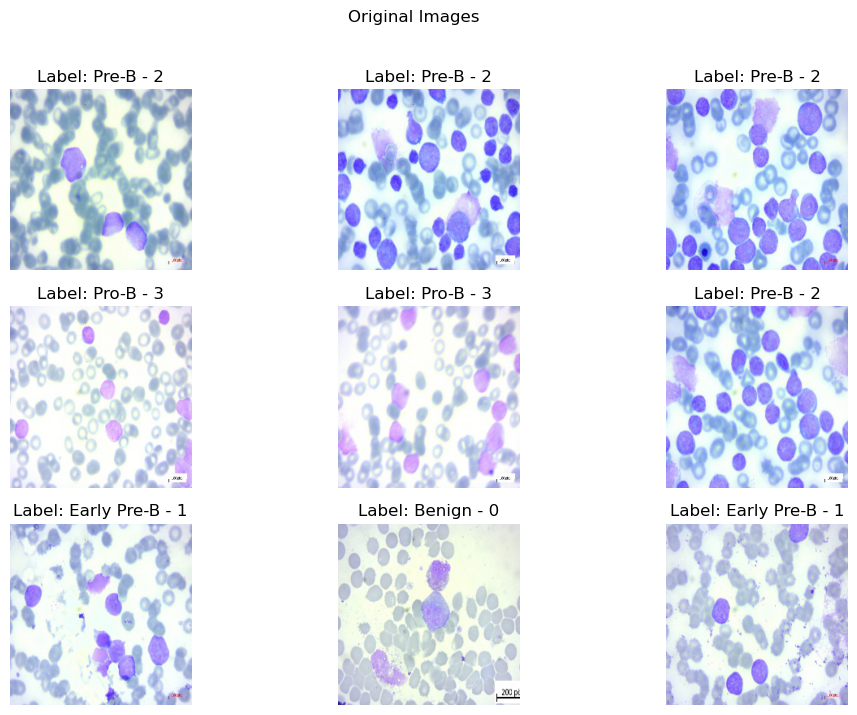

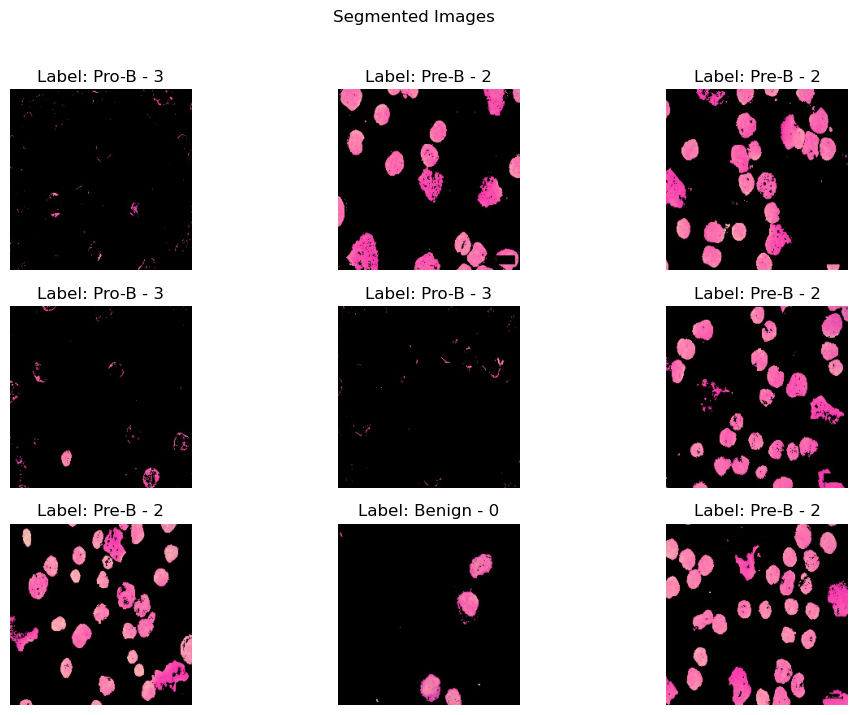

In [ ]:
def plot_sample_images(data_gen, title, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(9):
        img, label = data_gen.next()
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[0])
        class_index = np.argmax(label[0])
        plt.title(f"Label: {class_names[class_index]} - {class_index}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Define class names
class_names = ['Benign', 'Early Pre-B', 'Pre-B', 'Pro-B']

# Plot sample images
plot_sample_images(original_train_datagen, "Original Images", class_names)
plot_sample_images(segmented_train_datagen, "Segmented Images", class_names)

## SAVE AND LOAD model data and predictions

In [ ]:
#SAVE AND LOAD model data and predictions
def save_data_and_model(model, sample_images, sample_labels, predictions, model_path='model_combined.h5'):
    # Save the model
    model.save(model_path)

    # Save the data
    with open('sample_images.pkl', 'wb') as f:
        pickle.dump(sample_images, f)
    with open('sample_labels.pkl', 'wb') as f:
        pickle.dump(sample_labels, f)
    with open('predictions.pkl', 'wb') as f:
        pickle.dump(predictions, f)

def load_data_and_model(model_path='model_combined.h5'):
    # Load the model
    model = load_model(model_path)

    # Load the data
    with open('sample_images.pkl', 'rb') as f:
        sample_images = pickle.load(f)
    with open('sample_labels.pkl', 'rb') as f:
        sample_labels = pickle.load(f)
    with open('predictions.pkl', 'rb') as f:
        predictions = pickle.load(f)

    return model, sample_images, sample_labels, predictions

## Function to plot learning curve

In [ ]:
# Plot training and validation loss and accuracy
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()



# Model 1 (Original data) with CNN, Early stopping, Learning rate, L2 regularization and Batch normalization

Epoch 1/25
82/82 [==============================] - ETA: 0s - loss: 5.1689 - accuracy: 0.8849

C:\Users\jmnlg\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


82/82 [==============================] - 223s 3s/step - loss: 5.1689 - accuracy: 0.8849 - val_loss: 46.6797 - val_accuracy: 0.3035 - lr: 0.0010
Epoch 2/25
82/82 [==============================] - 209s 3s/step - loss: 2.3975 - accuracy: 0.9574 - val_loss: 32.8751 - val_accuracy: 0.3035 - lr: 0.0010
Epoch 3/25
82/82 [==============================] - 243s 3s/step - loss: 1.4109 - accuracy: 0.9689 - val_loss: 28.2162 - val_accuracy: 0.3035 - lr: 0.0010
Epoch 4/25
82/82 [==============================] - 288s 4s/step - loss: 1.0562 - accuracy: 0.9682 - val_loss: 7.0952 - val_accuracy: 0.3035 - lr: 0.0010
Epoch 5/25
82/82 [==============================] - 222s 3s/step - loss: 1.0862 - accuracy: 0.9551 - val_loss: 6.9584 - val_accuracy: 0.3313 - lr: 0.0010
Epoch 6/25
82/82 [==============================] - 213s 3s/step - loss: 0.8456 - accuracy: 0.9605 - val_loss: 12.8702 - val_accuracy: 0.3035 - lr: 0.0010
Epoch 7/25
82/82 [==============================] - 210s 3s/step - loss: 0.9944 - a

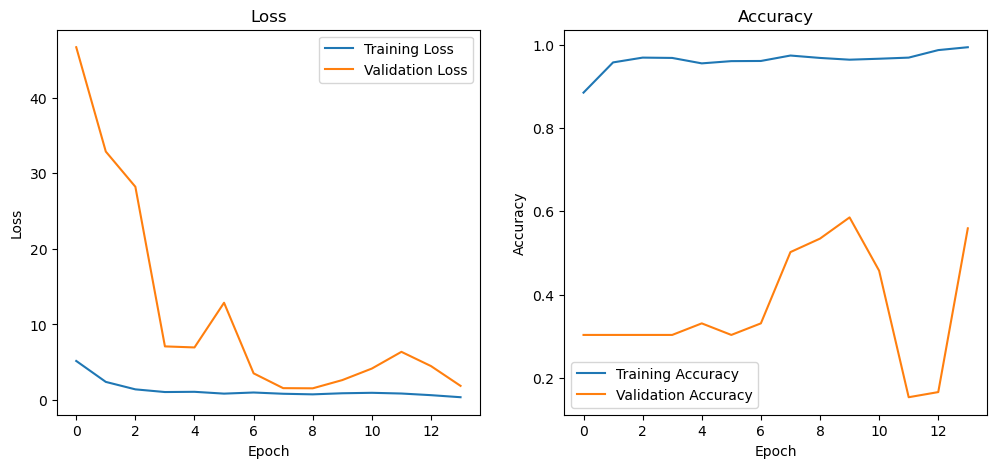

1/1 [==============================] - 1s 965ms/step


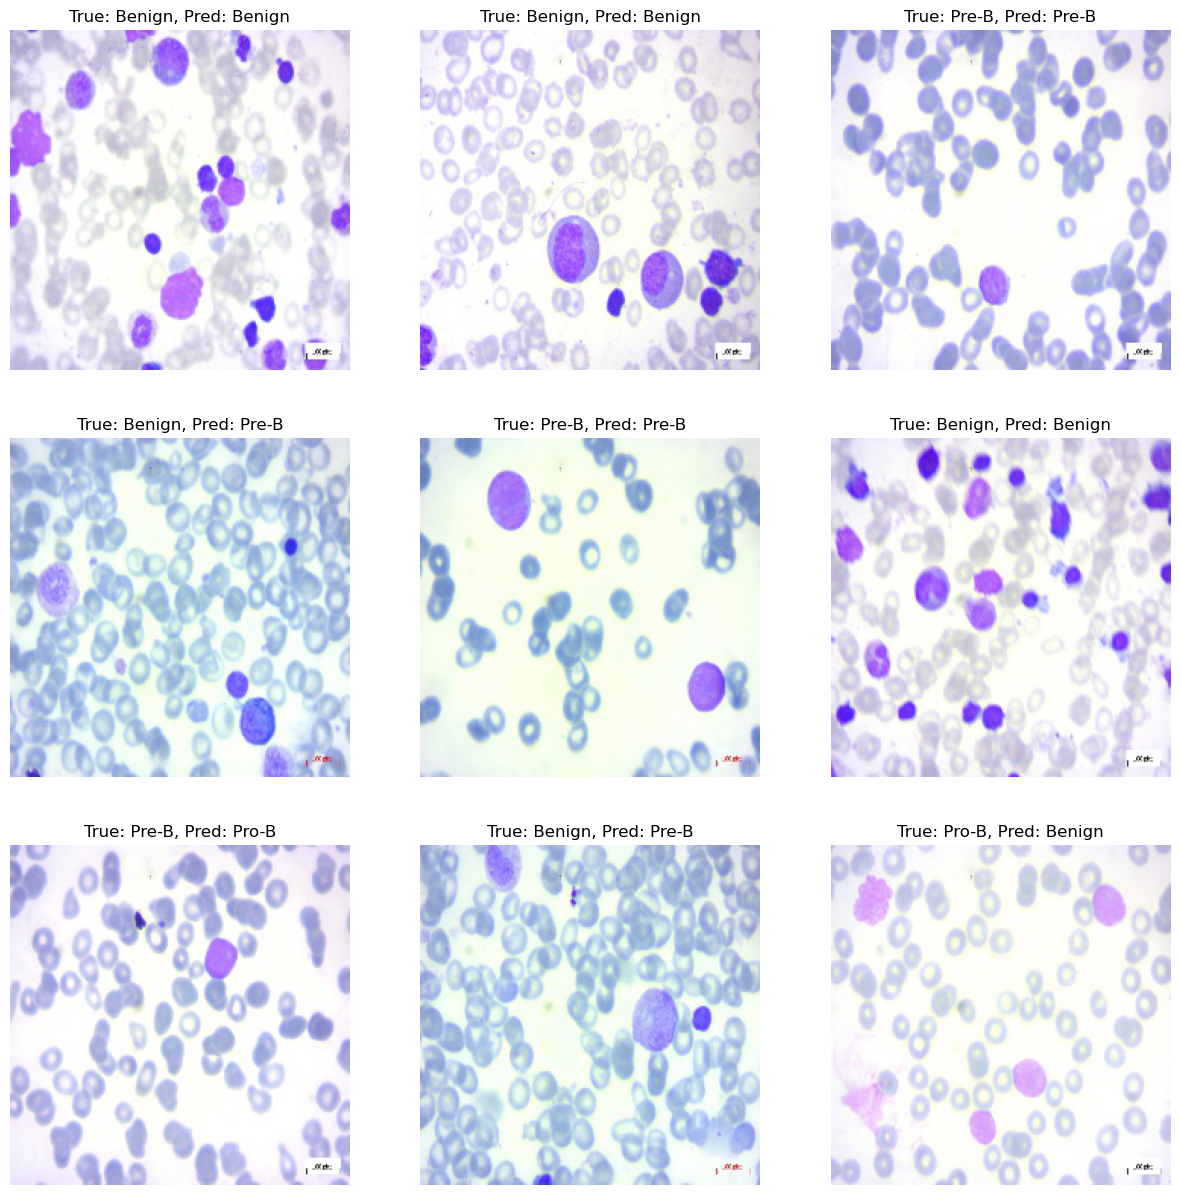

In [ ]:
# Define the CNN model with L2 regularization and Batch Normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    original_train_datagen,
    validation_data=original_val_datagen,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model.save('model.keras')

plot_history(history)


# Get a batch of validation data
sample_images, sample_labels = next(original_val_datagen)

# Predict the classes for the sample images
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
save_data_and_model(model, sample_images, sample_labels, predictions)

# Class names
class_names = ['Benign', 'Early Pre-B', 'Pre-B', 'Pro-B']

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    true_label = np.argmax(sample_labels[i])
    predicted_label = predicted_classes[i]
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
    plt.axis('off')
plt.show()

Observation:

* Model stopped at 14th epoch due to no improvement in val loss (1.5479)
*  Test accuracy: 99%, Validation accuracy: ~56% (potential overfitting)
* Training accuracy improved rapidly, reaching 98.70% by epoch 13.
* Training loss decreased from 5.1689 in epoch 1 to 0.3702 in the final epoch.
* Validation accuracy fluctuated, with the highest value of 58.55% in epoch 10.
* Validation loss was volatile, starting very high (46.6797) and ending at 1.8725
* In sample predictions image, the true labels are not many.

# Segmented data

Epoch 1/25
82/82 [==============================] - 222s 3s/step - loss: 6.0768 - accuracy: 0.7392 - val_loss: 12.9514 - val_accuracy: 0.2465 - lr: 0.0010
Epoch 2/25
82/82 [==============================] - 209s 3s/step - loss: 3.2903 - accuracy: 0.8746 - val_loss: 23.9091 - val_accuracy: 0.2465 - lr: 0.0010
Epoch 3/25
82/82 [==============================] - 205s 2s/step - loss: 2.2989 - accuracy: 0.8807 - val_loss: 19.5837 - val_accuracy: 0.2465 - lr: 0.0010
Epoch 4/25
82/82 [==============================] - 224s 3s/step - loss: 2.0635 - accuracy: 0.9022 - val_loss: 10.8431 - val_accuracy: 0.2573 - lr: 0.0010
Epoch 5/25
82/82 [==============================] - 213s 3s/step - loss: 2.2364 - accuracy: 0.9087 - val_loss: 8.7851 - val_accuracy: 0.2465 - lr: 0.0010
Epoch 6/25
82/82 [==============================] - 209s 3s/step - loss: 2.0924 - accuracy: 0.9125 - val_loss: 4.0701 - val_accuracy: 0.3975 - lr: 0.0010
Epoch 7/25
82/82 [==============================] - 206s 3s/step - loss:

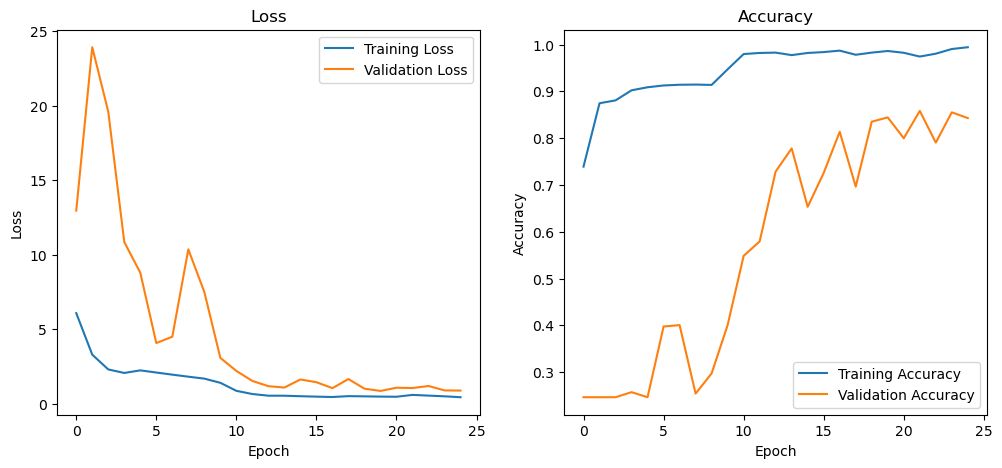

1/1 [==============================] - 1s 730ms/step


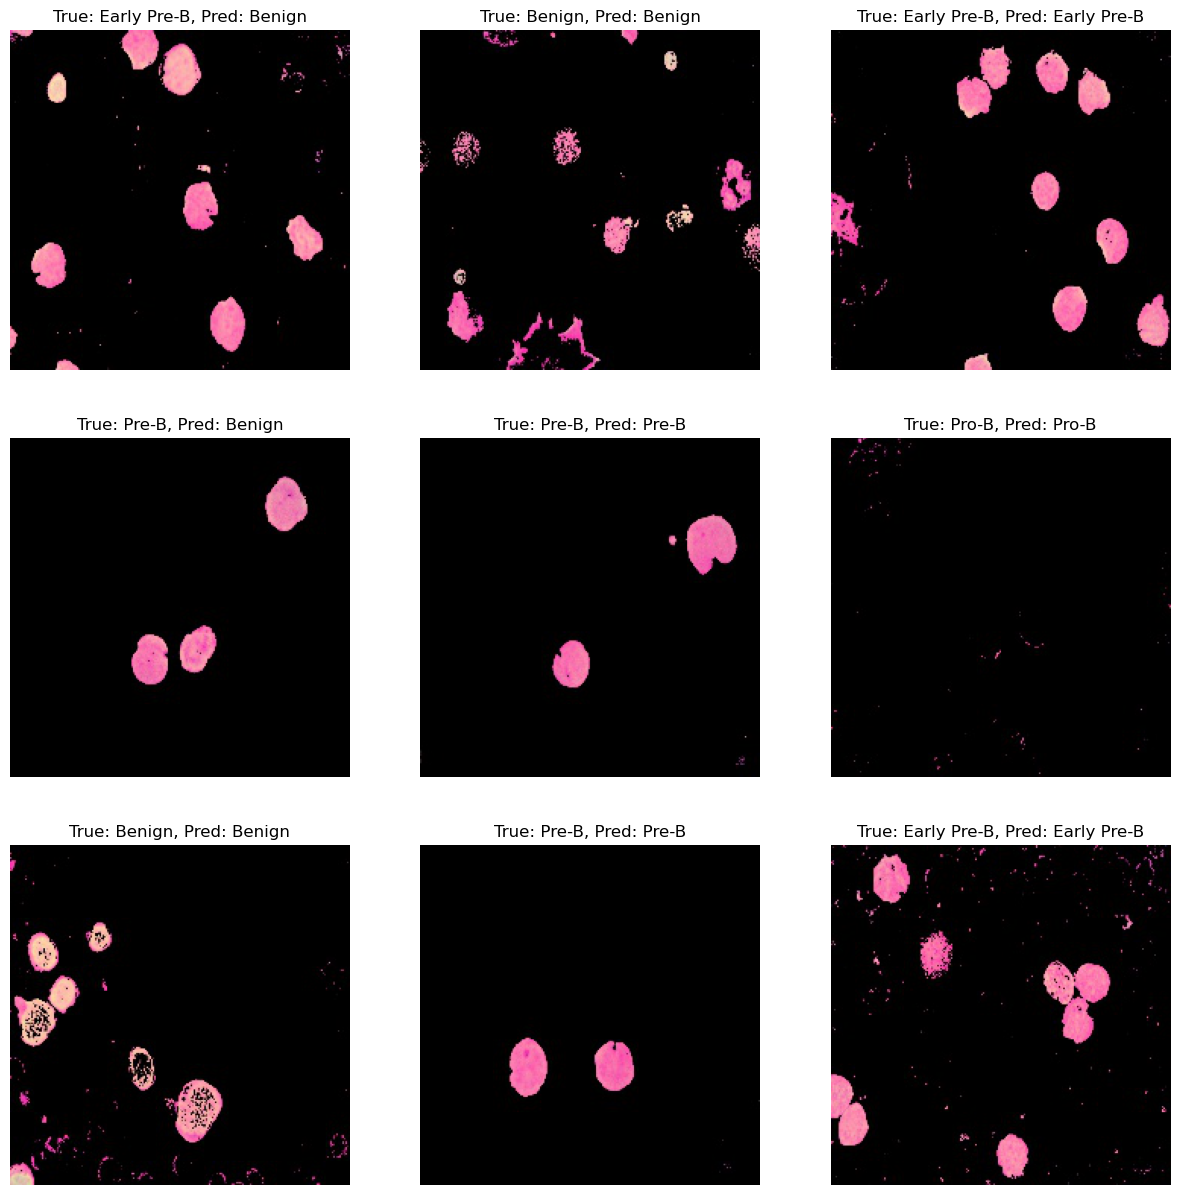

In [ ]:
# Define the CNN model with L2 regularization and Batch Normalization
model_seg = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model_seg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

checkpoint = ModelCheckpoint('model_seg.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model_seg
history_seg = model_seg.fit(
    segmented_train_datagen,
    validation_data=segmented_val_datagen,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model_seg.save('model_seg.keras')

plot_history(history_seg)

# Get a batch of validation data
sample_images, sample_labels = next(segmented_val_datagen)

# Predict the classes for the sample images
predictions = model_seg.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
save_data_and_model(model_seg, sample_images, sample_labels, predictions)

# Class names
class_names = ['Benign', 'Early Pre-B', 'Pre-B', 'Pro-B']

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    true_label = np.argmax(sample_labels[i])
    predicted_label = predicted_classes[i]
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
    plt.axis('off')
plt.show()


Observation:
* Training completed full 25 epochs
* Final metrics: loss: 0.4360, accuracy: 99.42%, val_loss: 0.8814, val_accuracy: 84.28%
* Learning rate adjusted twice: 0.001 → 0.0002 (epoch 10) → 0.00004 (epoch 24)
* Training accuracy improved steadily from 73.92% to 99.42%
* Validation accuracy increased significantly from 24.65% to 84.28%
* Initial overfitting reduced over time with improved generalization
* Best validation accuracy: 85.82% (epoch 22)

#Combined

In [ ]:
def combined_generator(gen1, gen2):
    while True:
        X1i, y1i = gen1.next()
        X2i, y2i = gen2.next()
        yield np.concatenate((X1i, X2i), axis=0), np.concatenate((y1i, y2i), axis=0)

combined_train_datagen = combined_generator(original_train_datagen, segmented_train_datagen)
combined_val_datagen = combined_generator(original_val_datagen, segmented_val_datagen)


Epoch 1/25
162/162 [==============================] - 813s 5s/step - loss: 3.9013 - accuracy: 0.7671 - val_loss: 5.5619 - val_accuracy: 0.2482 - lr: 0.0010
Epoch 2/25
162/162 [==============================] - 799s 5s/step - loss: 1.5484 - accuracy: 0.8855 - val_loss: 3.8347 - val_accuracy: 0.2888 - lr: 0.0010
Epoch 3/25
162/162 [==============================] - 790s 5s/step - loss: 1.1778 - accuracy: 0.9135 - val_loss: 4.1364 - val_accuracy: 0.2713 - lr: 0.0010
Epoch 4/25
162/162 [==============================] - 823s 5s/step - loss: 1.0681 - accuracy: 0.9204 - val_loss: 4.1545 - val_accuracy: 0.4439 - lr: 0.0010
Epoch 5/25
162/162 [==============================] - 802s 5s/step - loss: 1.0751 - accuracy: 0.9186 - val_loss: 4.9482 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 6/25
162/162 [==============================] - 792s 5s/step - loss: 0.6203 - accuracy: 0.9712 - val_loss: 0.8239 - val_accuracy: 0.8156 - lr: 2.0000e-04
Epoch 7/25
162/162 [==============================] - 790s 5

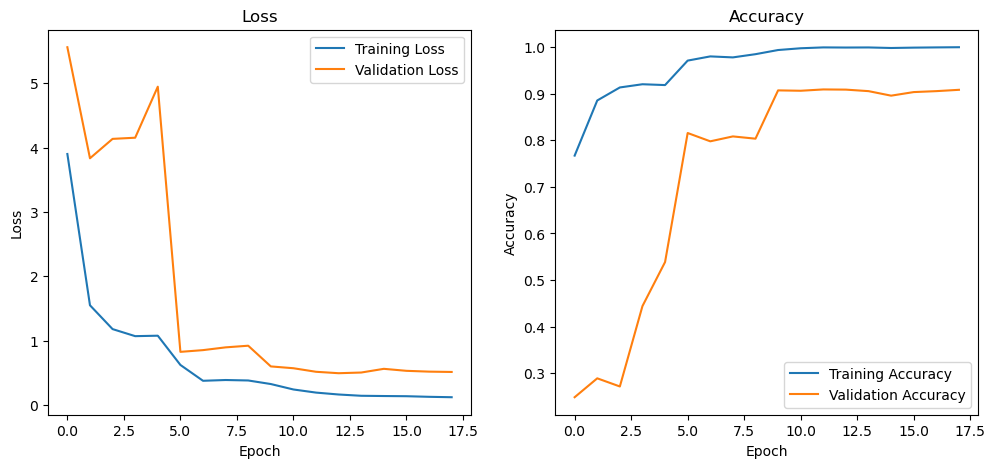

2/2 [==============================] - 2s 681ms/step


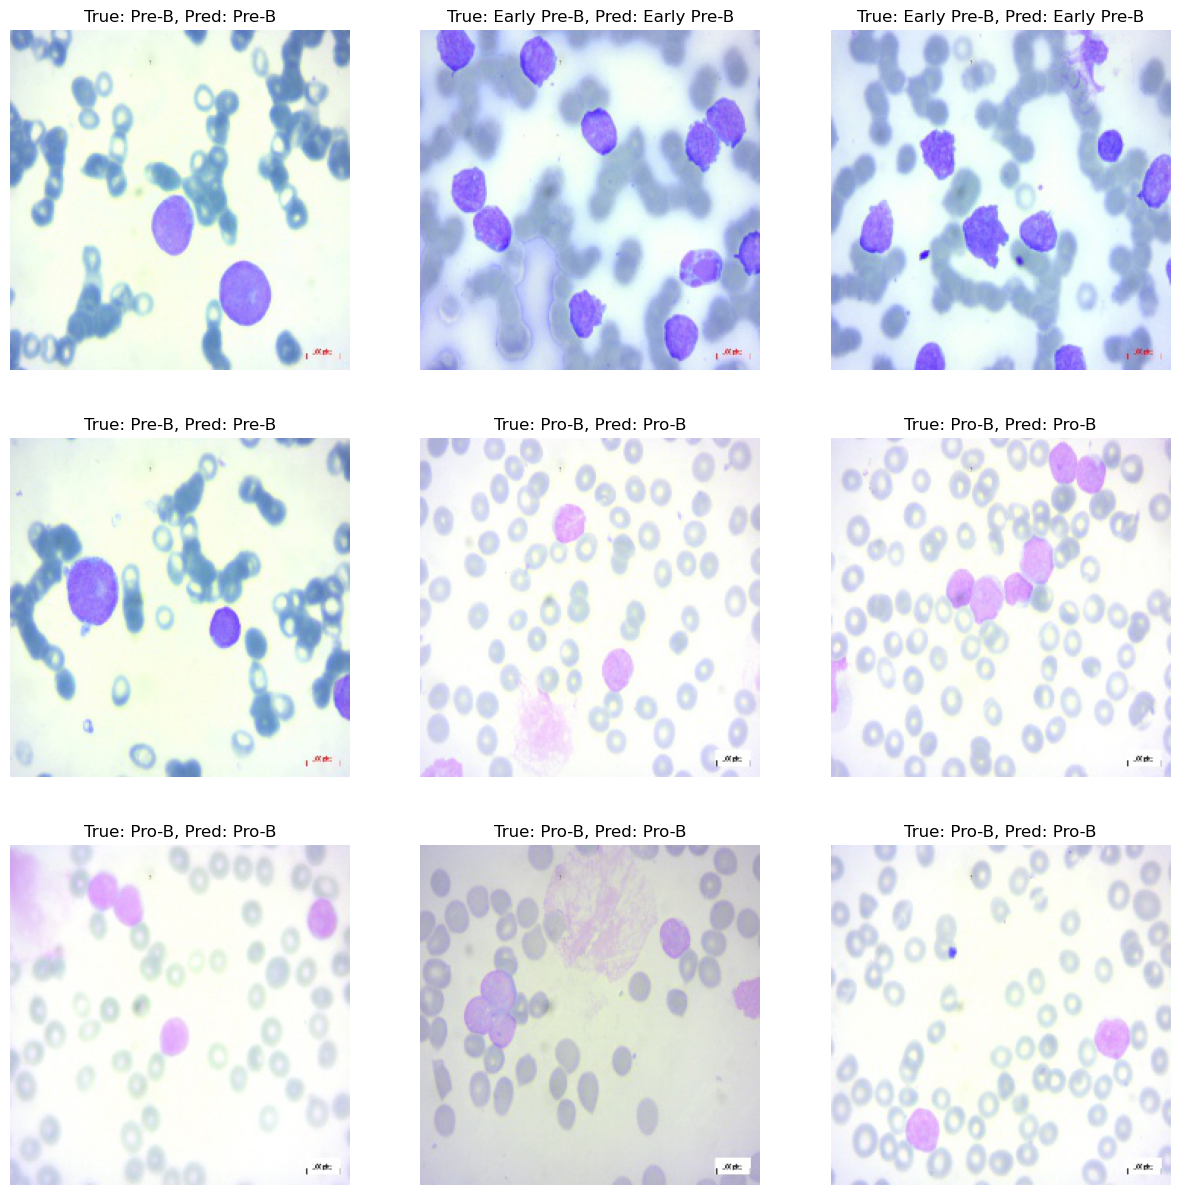

In [ ]:
# Define the CNN model with L2 regularization and Batch Normalization
batch_size = 32

# Calculate the number of steps per epoch for training
train_steps_per_epoch = sum([original_train_datagen.samples, segmented_train_datagen.samples]) // batch_size

# Calculate the number of validation steps
validation_steps = sum([original_val_datagen.samples, segmented_val_datagen.samples]) // batch_size

# Define the CNN model with L2 regularization and Batch Normalization
model_combined = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model_combined.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

checkpoint = ModelCheckpoint('model_combined.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history_combined = model_combined.fit(
    combined_train_datagen,
    validation_data=combined_val_datagen,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=validation_steps,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

model_combined.save('model_combined.keras')


# Call the plot_history function to visualize the training history
plot_history(history_combined)

# Get a batch of validation data
sample_images, sample_labels = next(combined_val_datagen)
save_data_and_model(model_combined, sample_images, sample_labels, predictions)

# Predict the classes for the sample images
predictions = model_combined.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Class names
class_names = ['Benign', 'Early Pre-B', 'Pre-B', 'Pro-B']

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    true_label = np.argmax(sample_labels[i])
    predicted_label = predicted_classes[i]
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
    plt.axis('off')
plt.show()


Observation:
* Training ran for 18 out of 25 planned epochs
* Final metrics: loss: 0.1183, accuracy: 99.99%, val_loss: 0.5112, val_accuracy: 90.84%
* Learning rate adjusted three times: 0.001 → 0.0002 (epoch 6) → 0.00004 (epoch 10) → 0.00001 (epoch 17)
* Training accuracy improved dramatically from 76.71% to 99.99%
* Validation accuracy increased significantly from 24.82% to 90.84%
* Best validation accuracy: 90.92% (epoch 12)
* Initial overfitting reduced with learning rate adjustments
* Model achieved very high training accuracy (>99.9%) from epoch 10 onwards
* Validation loss and accuracy stabilized in later epochs

2/2 [==============================] - 1s 598ms/step


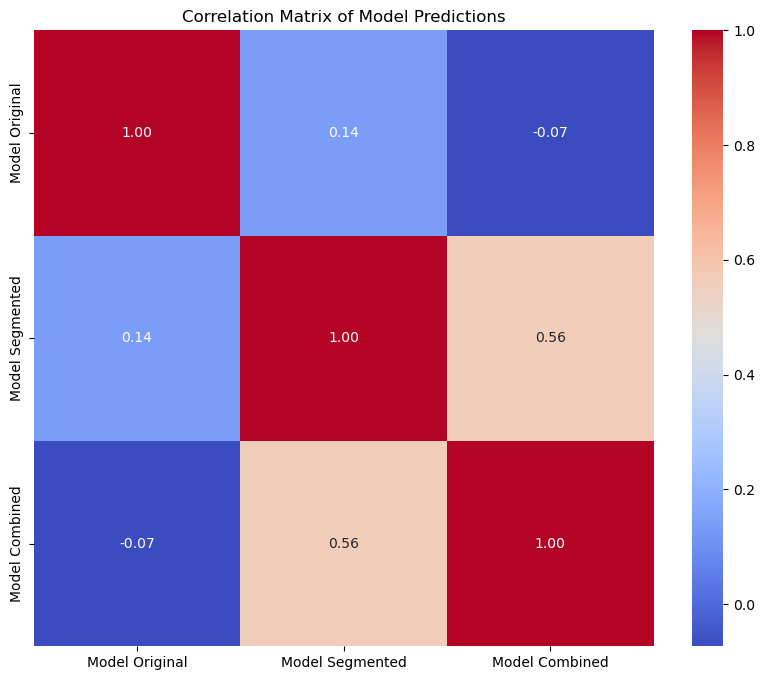

In [ ]:
#correlation matrix
predictions1 = model.predict(sample_images)
predictions_seg = model_seg.predict(sample_images)
predictions_combined = model_combined.predict(sample_images)

# Convert predictions to class labels
predicted_classes1 = np.argmax(predictions1, axis=1)
predicted_classes_seg = np.argmax(predictions_seg, axis=1)
predicted_classes_combined = np.argmax(predictions_combined, axis=1)

# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'Model Original': predicted_classes1,
    'Model Segmented': predicted_classes_seg,
    'Model Combined': predicted_classes_combined
})

# Calculate the correlation matrix
correlation_matrix = predictions_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Model Predictions')
plt.show()

Observation:
* Perfect self-correlation (1.00) for all models
* Weak positive correlation (0.14) between Original and Segmented models
* Slight negative correlation (-0.07) between Original and Combined models
* Moderate positive correlation (0.56) between Segmented and Combined models
* Combined model more similar to Segmented than Original model
* Original model shows least correlation with others, suggesting unique predictions
* Segmented and Combined models show highest inter-model agreement

# Future work
* Tweaking the model: We want to play around with the model's structure, maybe making it deeper or trying out different types of layers. It's like fine-tuning an engine to get better performance.
* Learning from others: We're considering using pre-trained models that have already learned from tons of images. It's like standing on the shoulders of giants to see further.
* Teaching the model to focus: We want to add something called "attention mechanisms." Imagine teaching the model to focus on the most important parts of an image, just like a doctor would.
* Strength in numbers: We might combine multiple models, each with its own strengths, to create a super-team of leukemia detectors.
* More practice makes perfect: We plan to feed our model more and more diverse images. The more it sees, the better it'll get at spotting leukemia.
* Reality check: We'll team up with actual doctors to test our model in real-world situations. Their feedback will be crucial to make sure our system is truly helpful in clinics.